# Import model

In [29]:
from os import X_OK
from __future__ import absolute_import, division, print_function, unicode_literals

try :
  %tensorflow_version 2.x
except Exception :
  pass
import numpy as np
import math, os, sys
import itertools

import matplotlib.pyplot as plt
plt.style.use('default')
from scipy import ndimage

from skimage import measure, morphology
from skimage.io import imsave, imread
from skimage.filters import threshold_otsu
from skimage.transform import resize

import tensorflow as tf
from sklearn import svm, datasets
from sklearn.metrics import confusion_matrix
import pandas as pd


Colab only includes TensorFlow 2.x; %tensorflow_version has no effect.


In [30]:
import tensorflow as tf
from tensorflow.keras.applications import ResNet152V2
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt


In [ ]:
print(tf.__version__)

2.17.1


Import Dataset

In [9]:
from google.colab import files
uploaded = files.upload()


Saving dataset.zip to dataset (1).zip


In [20]:
import zipfile

# Menentukan nama file ZIP yang telah diunggah
zip_file_path = "dataset.zip"  # Ganti dengan nama file ZIP yang telah diunggah

# Menentukan folder tujuan untuk ekstraksi
extract_folder = "/content/dataset"  # Folder tempat file akan diekstrak

# Ekstrak file ZIP
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(extract_folder)

print(f"File berhasil diekstrak ke {extract_folder}")


File berhasil diekstrak ke /content/dataset


In [21]:
import os

# Memeriksa isi folder setelah ekstraksi
os.listdir(extract_folder)


['images']

In [23]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Tentukan direktori untuk training dan validation
train_dir = '/content/dataset/images/Train'  # Ganti dengan path folder training
valid_dir = '/content/dataset/images/Test'  # Ganti dengan path folder validation

# Data augmentation untuk training
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Validasi hanya dinormalisasi
valid_datagen = ImageDataGenerator(rescale=1./255)

# Generator untuk training dan validation
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(150, 150),
    batch_size=32,
    class_mode='categorical'  # Ubah menjadi 'binary' jika dataset hanya 2 kelas
)

valid_generator = valid_datagen.flow_from_directory(
    valid_dir,
    target_size=(150, 150),
    batch_size=32,
    class_mode='categorical'
)


Found 2394 images belonging to 6 classes.
Found 0 images belonging to 0 classes.


# Build CNN

In [26]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam

# Membangun model CNN
model = Sequential()

# Layer konvolusi pertama
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(150, 150, 3)))
model.add(MaxPooling2D(2, 2))

# Layer konvolusi kedua
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(2, 2))

# Layer konvolusi ketiga
model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D(2, 2))

# Flatten layer untuk meratakan hasil dari convolutional layer
model.add(Flatten())

# Fully connected layer
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.5))  # Dropout untuk menghindari overfitting

# Output layer untuk klasifikasi
model.add(Dense(train_generator.num_classes, activation='softmax'))

# Kompilasi model
model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])

# Ringkasan model
model.summary()


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_6 (Conv2D)                    │ (None, 148, 148, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_9 (MaxPooling2D)       │ (None, 74, 74, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_7 (Conv2D)                    │ (None, 72, 72, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_10 (MaxPooling2D)      │ (None, 36, 36, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_8 (Conv2D)                    │ (None, 34, 34, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_11 (MaxPooling2D)      │ (None, 17, 17, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_2 (Flatten)                  │ (None, 36992)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 512)                 │      18,940,416 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_8 (Dense)                      │ (None, 6)                   │           3,078 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 19,036,742 (72.62 MB)

 Trainable params: 19,036,742 (72.62 MB)

 Non-trainable params: 0 (0.00 B)

In [33]:
print(train_generator.class_indices)  # Untuk melihat kelas-kelas dalam dataset
print(train_generator.samples)        # Jumlah sampel training
print(valid_generator.samples)        # Jumlah sampel validation


{'Acne': 0, 'Carcinoma': 1, 'Eczema': 2, 'Keratosis': 3, 'Milia': 4, 'Rosacea': 5}
2394
0


In [36]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest',
    validation_split=0.2  # Membagi 20% data untuk validasi
)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(150, 150),
    batch_size=32,
    class_mode='categorical',  # Sesuaikan jika multiklas atau binari
    subset='training'  # Menunjukkan subset pelatihan
)

valid_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(150, 150),
    batch_size=32,
    class_mode='categorical',  # Sesuaikan jika multiklas atau binari
    subset='validation'  # Menunjukkan subset validasi
)


Found 1920 images belonging to 6 classes.
Found 474 images belonging to 6 classes.


# visualization and training

Epoch 1/10
60/60 ━━━━━━━━━━━━━━━━━━━━ 131s 2s/step - accuracy: 0.4650 - loss: 1.3957 - val_accuracy: 0.5179 - val_loss: 1.2753
Epoch 2/10


/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 0.5385 - val_loss: 1.1883
Epoch 3/10
60/60 ━━━━━━━━━━━━━━━━━━━━ 129s 2s/step - accuracy: 0.5083 - loss: 1.2917 - val_accuracy: 0.5558 - val_loss: 1.2164
Epoch 4/10
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 0.7692 - val_loss: 0.9868
Epoch 5/10
60/60 ━━━━━━━━━━━━━━━━━━━━ 129s 2s/step - accuracy: 0.5172 - loss: 1.2651 - val_accuracy: 0.5491 - val_loss: 1.2198
Epoch 6/10
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 0.5000 - val_loss: 1.0797
Epoch 7/10
60/60 ━━━━━━━━━━━━━━━━━━━━ 134s 2s/step - accuracy: 0.4786 - loss: 1.3168 - val_accuracy: 0.5714 - val_loss: 1.1541
Epoch 8/10
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 0.5385 - val_loss: 1.3524
Epoch 9/10
60/60 ━━━━━━━━━━━━━━━━━━━━ 136s 2s/step - accuracy: 0.5188 - loss: 1.2246 - val_acc

Loss: 1.1003
Accuracy: 0.6076


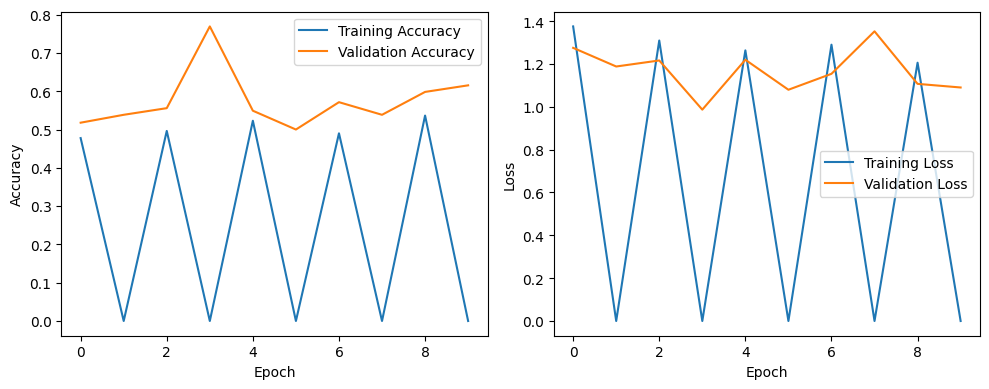

In [38]:


# Melatih model
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // train_generator.batch_size,
    epochs=10,  # Ubah jumlah epoch sesuai kebutuhan
    validation_data=valid_generator,
    validation_steps=valid_generator.samples // valid_generator.batch_size,
    verbose=1
)

# Evaluasi model
loss, accuracy = model.evaluate(valid_generator, verbose=0)
print(f"Loss: {loss:.4f}")
print(f"Accuracy: {accuracy:.4f}")

# Simpan model
model.save('model_dataset.h5')

# Plot akurasi dan loss
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

In [39]:
test_loss, test_acc = model.evaluate(valid_generator)
print(f"Test accuracy: {test_acc}")


15/15 ━━━━━━━━━━━━━━━━━━━━ 11s 737ms/step - accuracy: 0.5820 - loss: 1.1832
Test accuracy: 0.607594907283783


In [41]:
model.save('/content/skin_disease_model.h5')